In [114]:
import albumentations
import os, glob
import cv2
import numpy as np
import operator
import csv
import PIL 
np.random.seed(1)

config_dic = {
    'epoch': 1000,
    'n_fold': 5,
    'batch_size': 128,
    'num_workers': 3,
    'device': "cuda:5",
    'lr': 0.001
}

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def get_img_list():
    abs_path = '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset'
    
    # Dataset path
    sim_depth_path = os.path.join(abs_path, 'simulation_data/Depth')
    sim_sem_path = os.path.join(abs_path, 'simulation_data/SEM')
    
    train_path = os.path.join(abs_path, 'train')
    
    # only Test
    test_path = os.path.join(abs_path, 'test/SEM')
    
    sim_depth_img_path_dic = dict()
    for case in os.listdir(sim_depth_path):
        if not case in sim_depth_img_path_dic:
            sim_depth_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_depth_path, case)):
            img_list = glob.glob(os.path.join(sim_depth_path, case, folder, '*.png'))
            for img in img_list:
                sim_depth_img_path_dic[case].append(img)
                sim_depth_img_path_dic[case].append(img)

    sim_sem_img_path_dic = dict()
    for case in os.listdir(sim_sem_path):
        if not case in sim_sem_img_path_dic:
            sim_sem_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_sem_path, case)):
            img_list = glob.glob(os.path.join(sim_sem_path, case, folder, '*.png'))
            sim_sem_img_path_dic[case].extend(img_list)
    
    train_avg_depth = dict()
    with open(os.path.join(train_path, "average_depth.csv"), 'r') as csvfile:
        temp = csv.reader(csvfile)
        for idx, line in enumerate(temp):
            if idx > 0:
                depth_key, site_key = line[0].split('_site')
                depth_key = depth_key.replace("d", "D")
                site_key = "site" + site_key
                if not depth_key in train_avg_depth:
                    train_avg_depth[depth_key] = dict()

                train_avg_depth[depth_key][site_key] = float(line[1])
    
    train_img_path_dic = dict()
    for depth in os.listdir(os.path.join(train_path, "SEM")):
        if not depth in train_img_path_dic:
            train_img_path_dic[depth] = []
        for site in os.listdir(os.path.join(train_path, "SEM", depth)):
            img_list = glob.glob(os.path.join(train_path, "SEM", depth, site, "*.png"))
            train_img_path_dic[depth].extend([[temp_img, train_avg_depth[depth][site]]for temp_img in img_list])
    
    test_img_path_list = glob.glob(os.path.join(test_path, "*.png"))
    
    result_dic = dict()
    result_dic['sim'] = dict()
    result_dic['sim']['sem'] = sim_sem_img_path_dic
    result_dic['sim']['depth'] = sim_depth_img_path_dic
    result_dic['train'] = train_img_path_dic
    result_dic['test'] = np.array(test_img_path_list)
    result_dic['train_avg_depth'] = train_avg_depth
    
    return result_dic

result_dic = get_img_list()

In [3]:
## create k-fold
def K_fold(k, result_dic):
    # case1 case2 case3 case4
    # sim_sem(173,304) _itr0,1 <-> sem_depth(86,652) * 2
    def ret_chunk(path_dic):
        case_len_list = list(map(len, [path_dic[case] for case in path_dic])) # [43326, 43326, 43326, 43326] => [ [(0,11111) (11111,22222) (22222,33333) (33333,None)]
        def ret_slice_indices(k, size):
            chunk_size = int(size / k)
            _list = []
            for i in range(k):
                if i == k-1:
                    _list.append(slice(i * chunk_size, None))
                else:
                    _list.append(slice(i * chunk_size, (i + 1) * chunk_size))
            return _list

        case_list = [path_dic[case] for case in path_dic]
        slice_indice = list(map(ret_slice_indices, [k]*k, case_len_list))
        chunk_list = [[c[s] for s in slice_list] for c, slice_list in zip(case_list, slice_indice)]

        merge_chunk = [[] for i in range(k)]
        for c in chunk_list:
            for i, chunk in enumerate(c):
                merge_chunk[i].extend(chunk)

        return merge_chunk

    sim_sem_chunk = ret_chunk(result_dic['sim']['sem'])
    sem_depth_chunk = ret_chunk(result_dic['sim']['depth'])
    train_chunk = ret_chunk(result_dic['train'])

    chunk_dic = dict()
    chunk_dic['sim_sem'] = sim_sem_chunk
    chunk_dic['sim_depth'] = sem_depth_chunk
    chunk_dic['train'] = train_chunk

    return chunk_dic

chunk_dic = K_fold(config_dic['n_fold'], result_dic)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class sim_dataset(Dataset):
    def __init__(self, sem_data_list, depth_data_list, transform=None):
        super(sim_dataset, self).__init__()
        self.sem_data_list = sem_data_list
        self.depth_data_list = depth_data_list
        self.transform = transform

    def __getitem__(self, idx):
#         sem_img = cv2.imread(self.sem_data_list[idx], cv2.IMREAD_GRAYSCALE)
#         depth_img = cv2.imread(self.depth_data_list[idx], cv2.IMREAD_GRAYSCALE)
        sem_img = PIL.Image.open(self.sem_data_list[idx]).convert("L")
        depth_img = PIL.Image.open(self.depth_data_list[idx]).convert("L")
        if self.transform:
#             sem_transform_mask = np.random.uniform(0, 1, len(self.transform) - 1) >= 0.5
#             sem_transform_mask = np.append(sem_transform_mask, False)
#             depth_transform_mask = np.copy(sem_transform_mask)
#             depth_transform_mask[3] = False
#             sem_transform_mask[3] = True

#             for t, mask in zip(self.transform, sem_transform_mask):
#                 if mask:
#                     sem_img = t(image=sem_img)['image']

#             for t, mask in zip(self.transform, depth_transform_mask):
#                 if mask:
#                     depth_img = t(image=depth_img)['image']
#             depth_img = self.transform(image=depth_img)['image']
#             sem_img = self.transform(image=sem_img)['image']
            depth_img = self.transform(depth_img)
            sem_img = self.transform(sem_img)
            
        sem_img = np.array(sem_img)
        sem_img = sem_img.reshape(1, *sem_img.shape)
        depth_img = np.array(depth_img)
        depth_img = depth_img.reshape(1, *depth_img.shape)
        
#         print(type(sem_img), sem_img.shape)
        if not isinstance(sem_img, torch.Tensor):
            sem_img = torch.Tensor(sem_img)
            
        if not isinstance(depth_img, torch.Tensor):
            depth_img = torch.Tensor(depth_img)
        
        return (sem_img /255.0).type(torch.float32), (depth_img/255.0).type(torch.float32)

    def __len__(self):
        return len(self.sem_data_list)
#         return 10000

horizon_transform = A.Compose([
    A.HorizontalFlip(p=1.0, always_apply=True),
    ToTensorV2()
])


rotate_transform = A.Compose([
    A.Rotate([180, 180], p=1.0, always_apply=True),
    ToTensorV2()
])
color11_transform = A.Compose([
    A.ColorJitter(brightness=[0.9, 0.9], p=1.0, always_apply=True),
    ToTensorV2()
])

color12_transform = A.Compose([
    A.ColorJitter(brightness=[0.8, 0.8], p=1.0, always_apply=True),
    ToTensorV2()
])

vertical_transform = A.Compose([
    A.VerticalFlip(p=1.0, always_apply=True),
    ToTensorV2()
])

transform = A.Compose([
    ToTensorV2()
])

horizon_transform = transforms.RandomHorizontalFlip(1.0)
rotate_transform = transforms.RandomRotation((180,180))
vertical_transform = transforms.RandomVerticalFlip(1.0)
color11_transform = transforms.ColorJitter(brightness = [0.8, 0.8])
color12_transform = transforms.ColorJitter(brightness = [0.9, 0.9])
transform = None

transform_list = [horizon_transform, rotate_transform, color11_transform, color12_transform, vertical_transform]

In [6]:
dataset_list = []
for i in range(config_dic['n_fold']): # n_fold
    sem_train_data_list = []
    sem_valid_data_list = []
    depth_train_data_list = []
    depth_valid_data_list = []
    for j in range(config_dic['n_fold']):
        if i == j:
            sem_valid_data_list.extend(chunk_dic['sim_sem'][j])
            depth_valid_data_list.extend(chunk_dic['sim_depth'][j])
        else:
            sem_train_data_list.extend(chunk_dic['sim_sem'][j])
            depth_train_data_list.extend(chunk_dic['sim_depth'][j])

    dataset_list.append([sem_train_data_list, sem_valid_data_list, depth_train_data_list, depth_valid_data_list])

temp = []

for dataset in dataset_list:
    dataset_transform = []
    train_dataset = sim_dataset(sem_data_list=dataset[0],
                                depth_data_list=dataset[2],
                                transform=transform)
    valid_dataset = sim_dataset(sem_data_list=dataset[1],
                                depth_data_list=dataset[3],
                                transform=transform)
    dataset_transform.append([train_dataset, valid_dataset])
    print(len(train_dataset))
    for _transform in transform_list:
        train_dataset = sim_dataset(sem_data_list=dataset[0],
                                depth_data_list=dataset[2],
                                transform=_transform)
        valid_dataset = sim_dataset(sem_data_list=dataset[1],
                                    depth_data_list=dataset[3],
                                    transform=transform)
        dataset_transform.append([train_dataset, valid_dataset])
        print(len(train_dataset))
    
    train_dataset = dataset_transform[0][0] + dataset_transform[1][0] + dataset_transform[2][0] + dataset_transform[3][0] + dataset_transform[4][0] + dataset_transform[5][0]
    valid_dataset = dataset_transform[0][1] + dataset_transform[1][1] + dataset_transform[2][1] + dataset_transform[3][1] + dataset_transform[4][1] + dataset_transform[5][1]
    temp.append([train_dataset, valid_dataset])


folds_dataloader = [] # k개의 datalodaer를 저장함
for fold in temp:
    train_loader = DataLoader(fold[0], batch_size=config_dic['batch_size'], shuffle=True, num_workers=config_dic['num_workers'])
    valid_loader = DataLoader(fold[1], batch_size=config_dic['batch_size'], shuffle=False, num_workers=config_dic['num_workers'])

    folds_dataloader.append([train_loader, valid_loader])

138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138644
138640
138640
138640
138640
138640
138640


In [7]:
class AE_Model(nn.Module):
    def __init__(self):
        super(AE_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,64,3, stride=2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,3, stride=2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride=2, padding = 1),
            nn.ReLU()
            )
        
        self.flatten = nn.Sequential(nn.Flatten(start_dim = 1),
                                     nn.Dropout(0.2))

        self.encoder_lin = nn.Sequential(
            nn.Linear(256*9*6,2048),
            nn.ReLU(),
            nn.Linear(2048, 256*9*6),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size = (256,9,6))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding = 1,output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3, stride=2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,1,3, stride=2, padding = 1, output_padding = 1)
        )
        
    def forward(self, x):
        x = self.encoder(x)

        x = self.flatten(x)
        x = self.encoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder(x)                                                     # decoder 를 빠져나온 x는 추정된 depth map이 일렬로 쭉 늘어져 있는 것 

        return x

In [8]:
def imshow(img):
    from IPython.display import display, Image
    print(img.shape, np.max(img[0]), img[0][:10], np.mean(img), np.min(img[0]))
    _, ret = cv2.imencode('.jpg', img)
    img = Image(data=ret)
    display(img)

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, optimizer, train_lodaer, val_loader, schedular, epochs, device, n_fold):
    model.to(device)

    
    best_rmse_loss = 9999
    best_model = model
    
    
    for epoch in range(epochs):
        model.train()
        mean_list = [[],[],[],[]]
        pred_mean_list = [[],[],[],[]]
        epoch_loss = []
        for step_i, (sem_img, depth_img) in enumerate(tqdm(train_lodaer)):
                    
            sem_img = sem_img.to(device, non_blocking=True)
            depth_img = depth_img.to(device, non_blocking=True)
            optimizer.zero_grad()
            pred_depth_img = model(sem_img)
            loss = criterion(pred_depth_img, depth_img)
            
            for img_i in range(depth_img.shape[0]):
                
                _depth_idx = int(depth_img[img_i][0][0][0].item() * 255)
                if _depth_idx == 140:
                    mean_list[0].append(np.mean(sem_img[img_i].detach().cpu().numpy()) * 255)
                    pred_mean_list[0].append(np.mean(pred_depth_img[img_i].detach().cpu().numpy()) * 255)
                if _depth_idx == 150:
                    mean_list[1].append(np.mean(sem_img[img_i].detach().cpu().numpy()) * 255)
                    pred_mean_list[1].append(np.mean(pred_depth_img[img_i].detach().cpu().numpy()) * 255)                         
                if _depth_idx == 160:
                    mean_list[2].append(np.mean(sem_img[img_i].detach().cpu().numpy()) * 255)
                    pred_mean_list[2].append(np.mean(pred_depth_img[img_i].detach().cpu().numpy()) * 255)
                if _depth_idx == 170:
                    mean_list[3].append(np.mean(sem_img[img_i].detach().cpu().numpy()) * 255)
                    pred_mean_list[3].append(np.mean(pred_depth_img[img_i].detach().cpu().numpy()) * 255)
            
            
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
        
        schedular.step()

        rmse_loss = validation(model, val_loader, epoch, device, n_fold, criterion)
        print(f"{n_fold}번쨰/ epoch:{epoch} / train_loss:{round(sum(epoch_loss)/len(epoch_loss), 5)} / valid_rmse:{rmse_loss}")
        plt.rcParams['figure.figsize'] = [20, 5]
        plt.subplot(1,2,1)
        print(len(mean_list[0]))
        plt.hist(mean_list[0], bins=100, density=True, label="110", color="red", alpha=0.5)
        plt.hist(mean_list[1], bins=100, density=True, label="120", color="blue", alpha=0.5)
        plt.hist(mean_list[2], bins=100, density=True, label="130", color="green", alpha=0.5)
        plt.hist(mean_list[3], bins=100, density=True, label="140", color="black", alpha=0.5)
        plt.title("train sim sem image graph")
                                             
        plt.subplot(1,2,2)
        print(len(pred_mean_list[0]))
        plt.hist(pred_mean_list[0], bins=100, density=True, label="110", color="red", alpha=0.5)
        plt.hist(pred_mean_list[1], bins=100, density=True, label="120", color="blue", alpha=0.5)
        plt.hist(pred_mean_list[2], bins=100, density=True, label="130", color="green", alpha=0.5)
        plt.hist(pred_mean_list[3], bins=100, density=True, label="140", color="black", alpha=0.5)
        plt.title("sim sem predicted image graph")
        plt.legend()
#         plt.xlim(85, 150)
        plt.show()
        
        plt.clf()
        plt.cla()
        plt.close()
        if rmse_loss < best_rmse_loss:
            best_model = model
            best_epoch = epoch
            best_rmse_loss = rmse_loss
            best_train_loss = sum(epoch_loss)/len(epoch_loss)

    print(f"best model epoch-{best_epoch} / rmse:{best_rmse_loss}/ train_loss:{best_train_loss}")
    return best_model, best_epoch, best_rmse_loss, best_train_loss

In [10]:
def validation(model, val_loader, epoch, device, n_fold, criterion):
    model.eval()
    mse_criterion = nn.MSELoss().to(device)

    with torch.no_grad():
        valid_loss = []
        depth_mean_list = []
        for sem_img, depth_img in tqdm(val_loader):
            sem_img = sem_img.to(device)
            depth_img = depth_img.to(device)
            
            pred = model(sem_img)
            pred = (pred * 255).type(torch.int8).float()
            
            np_depth = (depth_img * 255).type(torch.int8).float().cpu().numpy()
            np_pred = pred.cpu().numpy()
            
            true = (depth_img * 255).type(torch.int8).float()
            mse_loss = torch.sqrt(criterion(pred, true))
            
            valid_loss.append(mse_loss.item())
        rmse_loss = np.mean(valid_loss)

    return rmse_loss

train 6499 valid 1625


  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:0 / train_loss:0.02251 / valid_rmse:3.0449167659466085
138644
138644


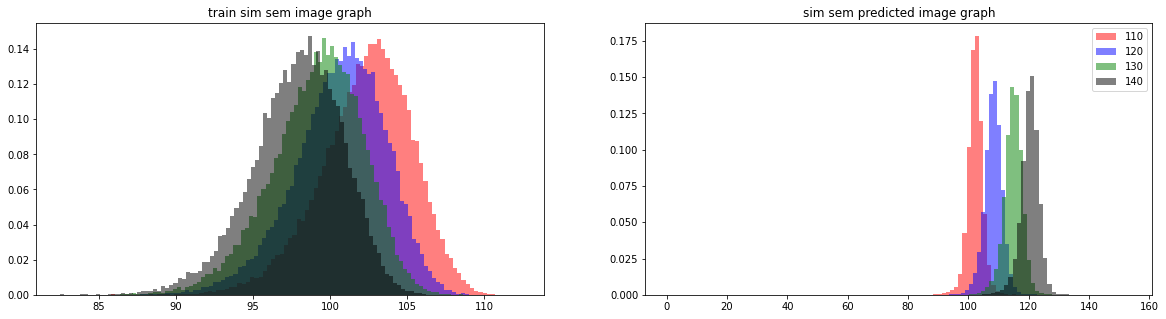

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:1 / train_loss:0.01748 / valid_rmse:2.9670140897310695
138644
138644


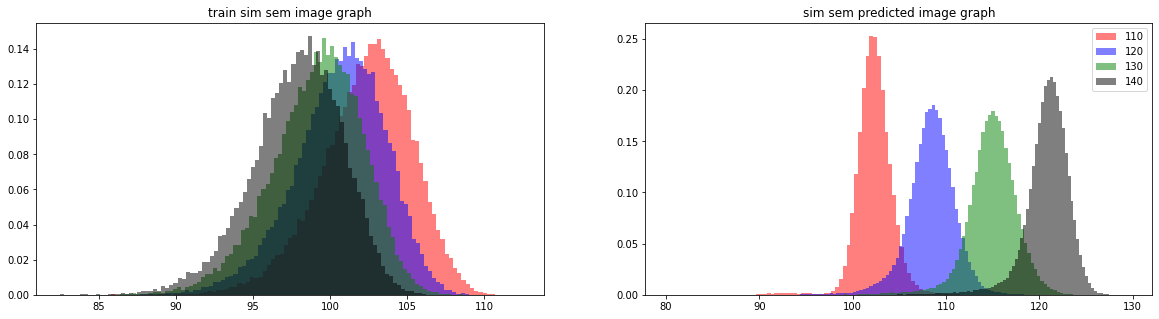

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:2 / train_loss:0.01589 / valid_rmse:2.968154258141151
138644
138644


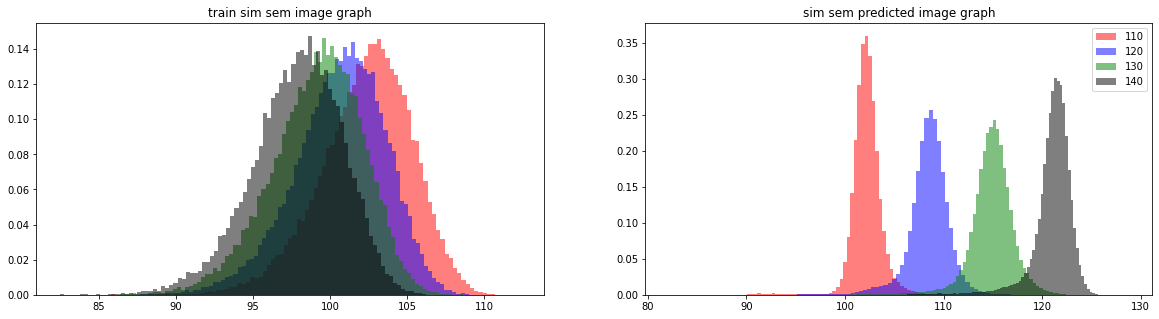

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:3 / train_loss:0.01501 / valid_rmse:2.9911025012089656
138644
138644


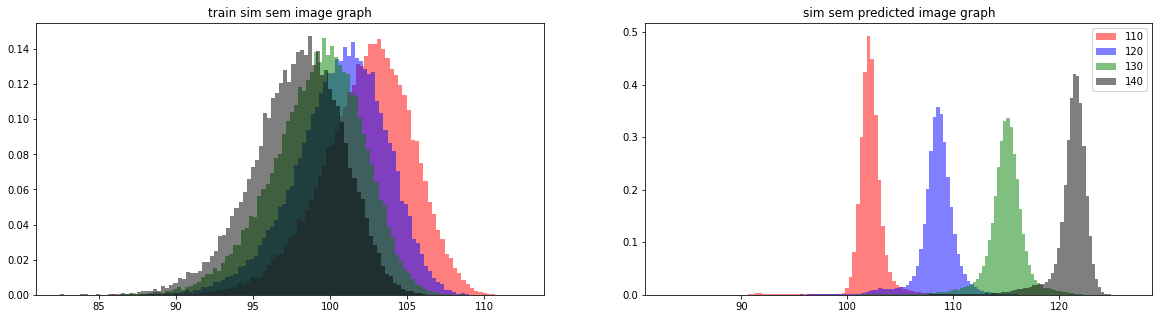

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:4 / train_loss:0.01446 / valid_rmse:2.92611402291518
138644
138644


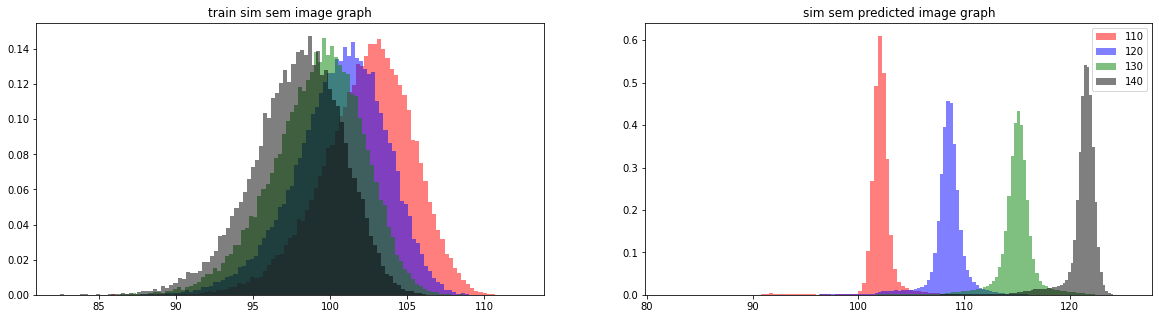

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:5 / train_loss:0.01416 / valid_rmse:2.9034921738551214
138644
138644


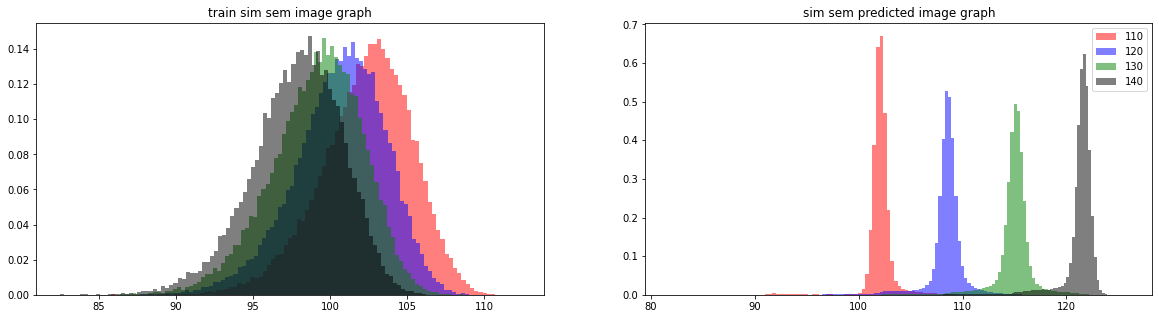

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:6 / train_loss:0.01386 / valid_rmse:2.941882087120643
138644
138644


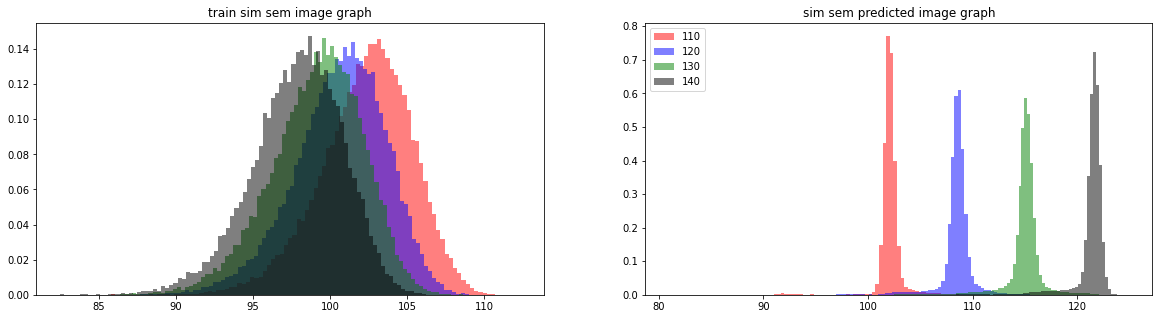

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:7 / train_loss:0.01365 / valid_rmse:2.9207208448556754
138644
138644


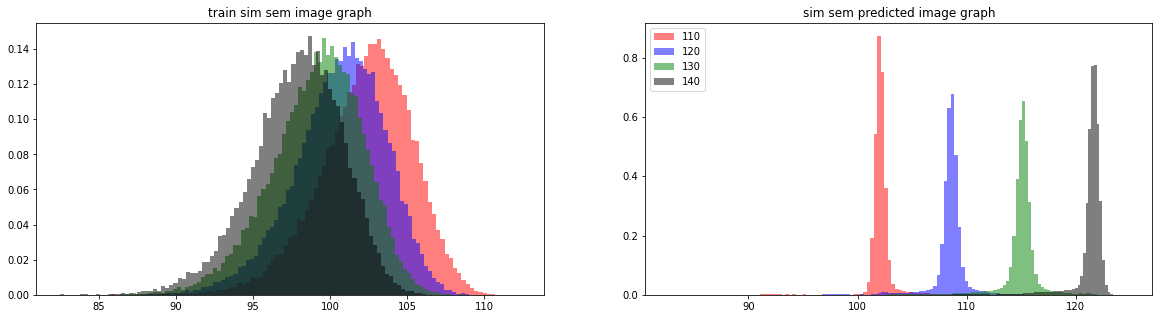

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:8 / train_loss:0.01346 / valid_rmse:2.9984441343454216
138644
138644


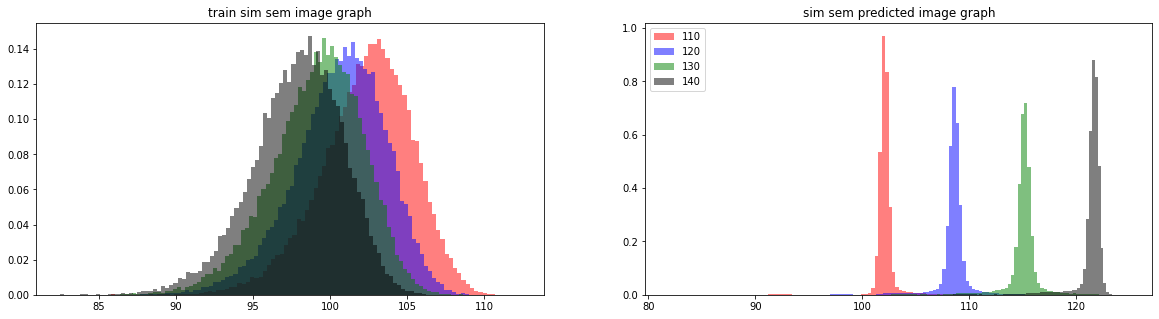

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:9 / train_loss:0.01332 / valid_rmse:2.9098681618617133
138644
138644


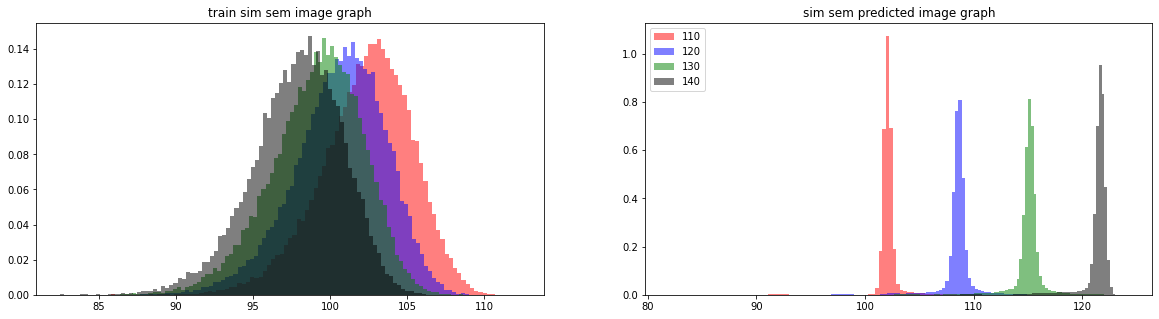

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:10 / train_loss:0.01319 / valid_rmse:2.943392028074998
138644
138644


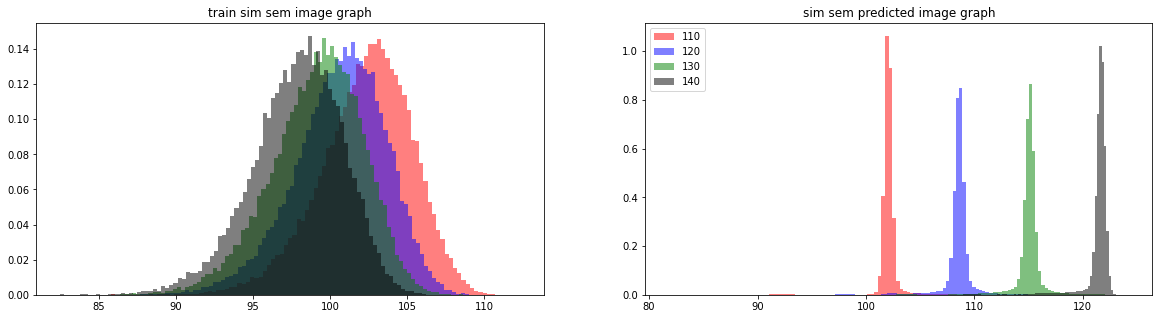

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:11 / train_loss:0.01307 / valid_rmse:2.8852231930952805
138644
138644


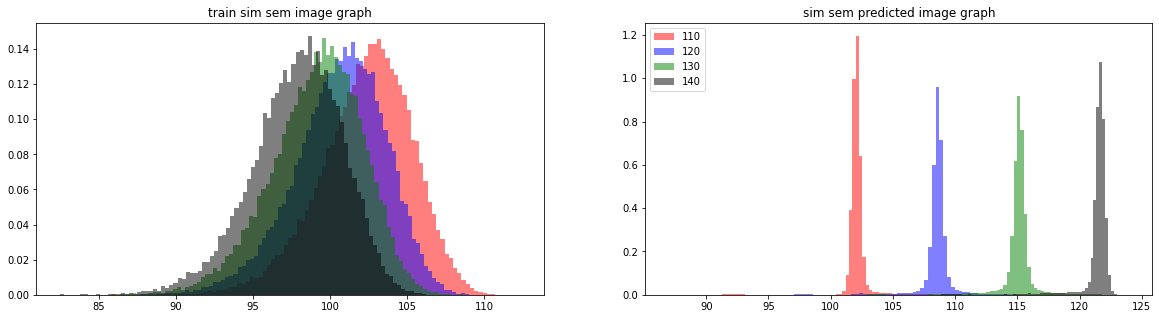

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:12 / train_loss:0.01299 / valid_rmse:2.917219260289119
138644
138644


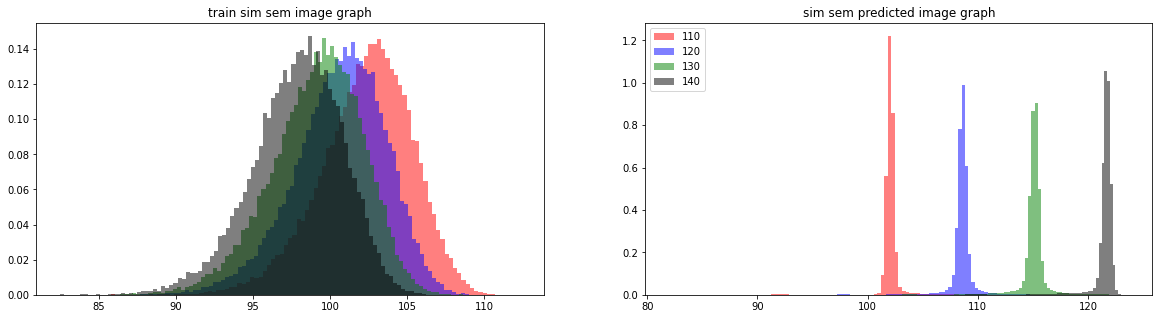

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:13 / train_loss:0.0129 / valid_rmse:2.923701961223896
138644
138644


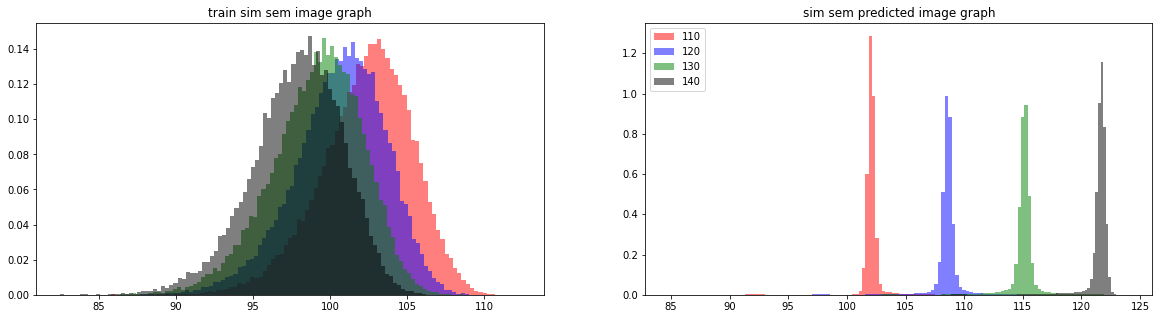

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:14 / train_loss:0.0128 / valid_rmse:2.811991067299476
138644
138644


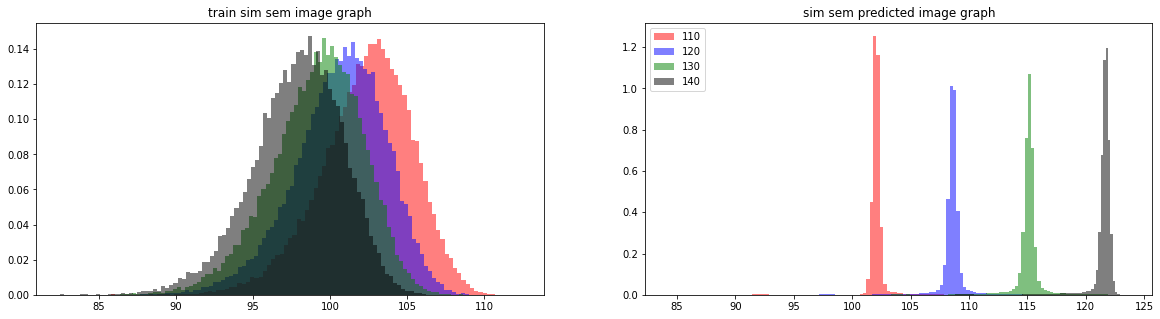

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:15 / train_loss:0.01274 / valid_rmse:2.9498306896503155
138644
138644


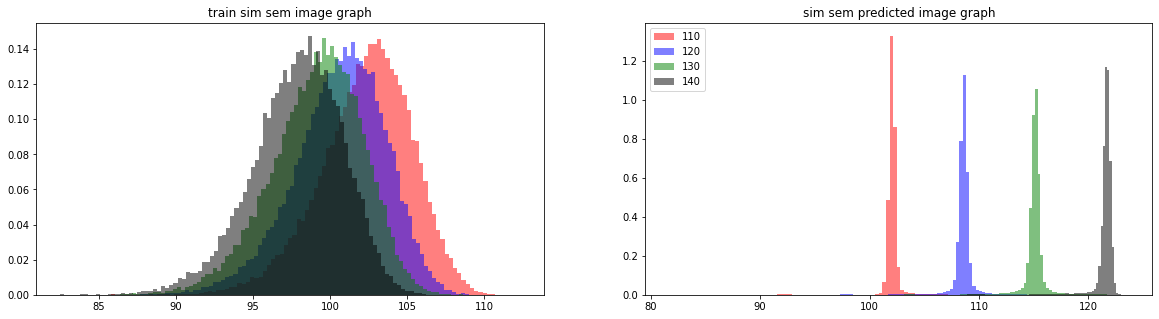

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:16 / train_loss:0.01265 / valid_rmse:2.916652986233051
138644
138644


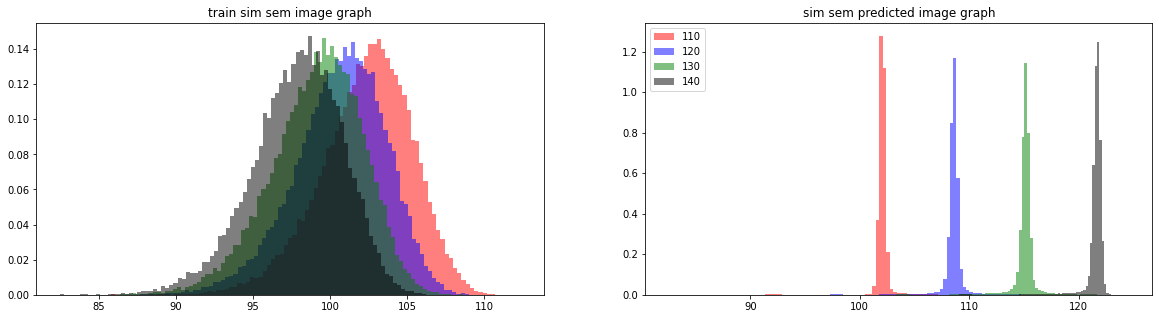

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:17 / train_loss:0.01259 / valid_rmse:2.918124667241023
138644
138644


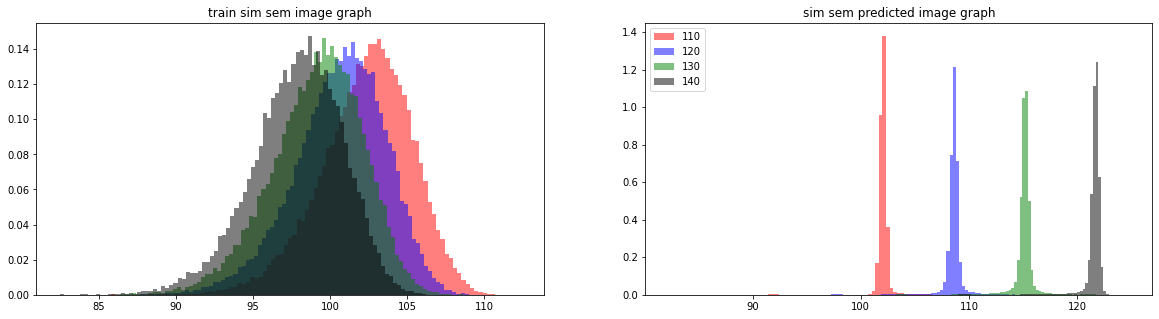

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:18 / train_loss:0.01252 / valid_rmse:2.9260706919156587
138644
138644


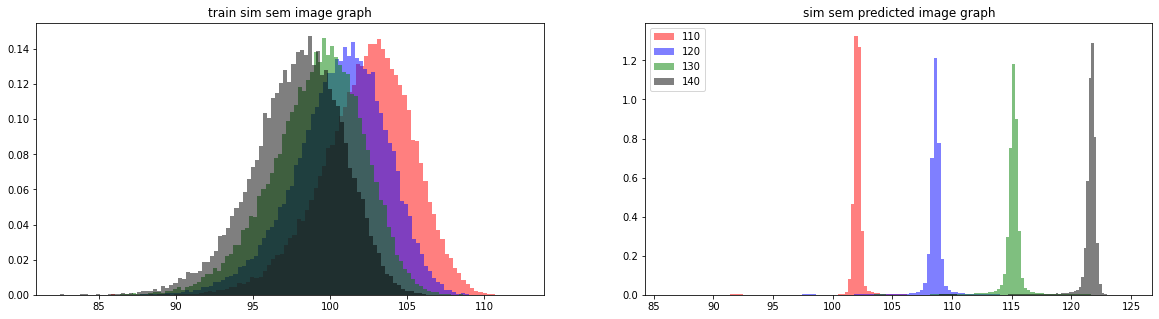

  0%|          | 0/6499 [00:00<?, ?it/s]

  0%|          | 0/1625 [00:00<?, ?it/s]

0번쨰/ epoch:19 / train_loss:0.01245 / valid_rmse:2.9051973491081826
138644
138644


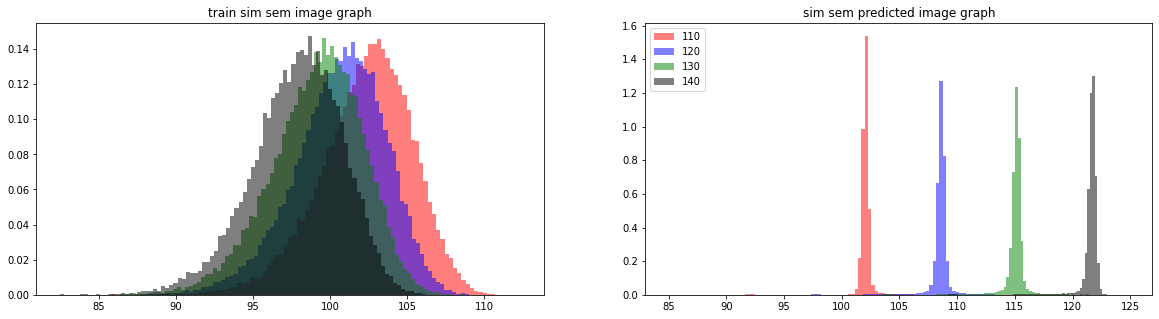

best model epoch-14 / rmse:2.811991067299476/ train_loss:0.012803261953168584


In [11]:
best_model_list = []
for fold_i, data_loaders in enumerate(folds_dataloader):
    print("train",len(data_loaders[0]),"valid",len(data_loaders[1]))
    model = AE_Model()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=config_dic['lr'])
    schedular = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
    criterion = nn.L1Loss().to(device=config_dic['device'])
    best_model,best_epoch, best_rmse_loss, best_train_losss = train(model, optimizer, data_loaders[0], 
                       data_loaders[1], schedular, 20, config_dic['device'], fold_i)
    best_model_list.append([best_model,best_epoch, best_rmse_loss, best_train_losss])
    if fold_i == 0:
        break

In [12]:
len(chunk_dic['train'][0])

12132

In [18]:
print(best_model_list)
torch.save(best_model_list[0][0], 'best_model_221206.pt')

[[AE_Model(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=13824, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=13824, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 9, 6))
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d

In [13]:
train_data_path = chunk_dic['train'][0] + chunk_dic['train'][1] + chunk_dic['train'][2] + chunk_dic['train'][3] + chunk_dic['train'][4]
print(len(train_data_path))

60664


In [14]:
class train_dataset(Dataset):
    def __init__(self, data_path, transform):
        super(train_dataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        img_path, avg_depth = self.data_path[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        
        return (img / 255.0).type(torch.float32), avg_depth
    
train_trasform = A.Compose([
    ToTensorV2()
])

train_dataset = train_dataset(train_data_path, train_trasform)
train_dataloader = DataLoader(train_dataset, batch_size=config_dic['batch_size'], shuffle=False, num_workers=config_dic['num_workers'])

In [15]:
import math

def train_imshow(img):
    from IPython.display import display, Image
    print(img.shape, np.max(img[0]), img[0][:10], np.mean(img), np.min(img[0]))
    _, ret = cv2.imencode('.jpg', img)
    img = Image(data=ret)
    display(img)

def add_train(model, epochs, dataloader, device):
    model.eval()
    
    for epoch in range(epochs):
        pred_mean_list = [[],[],[],[]]
        train_mean_list = [[],[],[],[]]
        
        avg_depth_list = [[],[],[],[]]
        for step_i, (sem_img, avg_depth)in enumerate(dataloader):
            sem_img = sem_img.to(device=device)
            pred = model(sem_img)
            for img_i in range(sem_img.shape[0]):
                np_pred = (pred[img_i].detach().cpu().numpy() * 255).astype(np.uint8)[0]
                np_sem = (sem_img[img_i].detach().cpu().numpy() * 255).astype(np.uint8)[0]
                d = int(round(avg_depth[img_i].item(), -1))
                # 첫줄 중앙값
                p1 = np.median(np_pred[0])
                # 중앙 줄에서 min 값
                p2 = np.min(np_pred[0])
                
                if d == 110:
                    pred_mean_list[0].append(np.mean(np_pred))
                    train_mean_list[0].append(np.mean(np_sem))
                    avg_depth_list[0].append(p2)
                elif d == 120:
                    pred_mean_list[1].append(np.mean(np_pred))
                    train_mean_list[1].append(np.mean(np_sem))
                    avg_depth_list[1].append(p2)
                elif d == 130:
                    pred_mean_list[2].append(np.mean(np_pred))
                    train_mean_list[2].append(np.mean(np_sem))
                    avg_depth_list[2].append(p2)
                elif d == 140:
                    pred_mean_list[3].append(np.mean(np_pred))
                    train_mean_list[3].append(np.mean(np_sem))
                    avg_depth_list[3].append(p2)
        
        plt.rcParams['figure.figsize'] = [20, 10]
        
        plt.subplot(2,2,1)
        plt.hist(pred_mean_list[0], bins=100, color='red', alpha=0.5, density=True, label="110")
        plt.hist(pred_mean_list[1], bins=100, color='blue', alpha=0.5, density=True, label="120")
        plt.hist(pred_mean_list[2], bins=100, color='green', alpha=0.5, density=True, label="130")
        plt.hist(pred_mean_list[3], bins=100, color='black', alpha=0.5, density=True, label="140")
        plt.title("predicted image")
        plt.legend()
        
        plt.subplot(2,2,2)
        plt.hist(train_mean_list[0], bins=100, color='red', alpha=0.5, density=True, label="110")
        plt.hist(train_mean_list[1], bins=100, color='blue', alpha=0.5, density=True, label="120")
        plt.hist(train_mean_list[2], bins=100, color='green', alpha=0.5, density=True, label="130")
        plt.hist(train_mean_list[3], bins=100, color='black', alpha=0.5, density=True, label="140")
        plt.title("train sem Image")
        plt.legend()
        
        
        plt.subplot(2,2,3)
        plt.hist(avg_depth_list[0], bins=100, color='red', alpha=0.5, density=True, label="110")
        plt.hist(avg_depth_list[1], bins=100, color='blue', alpha=0.5, density=True, label="120")
        plt.hist(avg_depth_list[2], bins=100, color='green', alpha=0.5, density=True, label="130")
        plt.hist(avg_depth_list[3], bins=100, color='black', alpha=0.5, density=True, label="140")
        plt.title("avg depth")
        plt.legend()
        print(np.mean(avg_depth_list[0]))
        print(np.mean(avg_depth_list[1]))
        print(np.mean(avg_depth_list[2]))
        print(np.mean(avg_depth_list[3]))
        
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()
    return avg_depth_list, train_mean_list, pred_mean_list

140.88381906897007
149.17489347754835
158.5951283739302
168.01421643526209


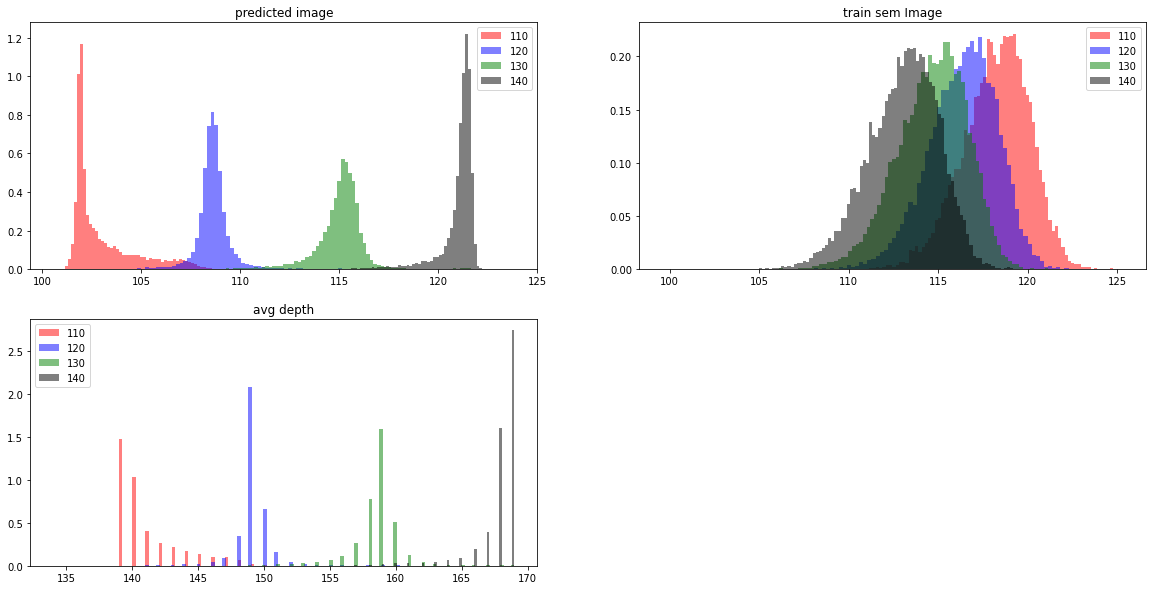

In [16]:
avg_depth_list, train_mean_list, pred_mean_list = add_train(best_model_list[0][0], 1, train_dataloader, config_dic['device'])

In [39]:
round(136.77,-1)

140.0

In [93]:
add_train_data_path = chunk_dic['train'][0] + chunk_dic['train'][1] + chunk_dic['train'][2] + chunk_dic['train'][3] 
add_valid_data_path = chunk_dic['train'][4]

print(len(train_data_path))

class add_train_dataset(Dataset):
    def __init__(self, data_path, transform):
        super(add_train_dataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        img_path, avg_depth = self.data_path[idx]
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = PIL.Image.open(img_path).convert("L")
#         print(np.array(img).shape)
        if self.transform:
            img = self.transform(img)
            
        img = np.array(img)
        img = img.reshape(1, *img.shape)
        img = torch.Tensor(img)
       

        avg_depth = np.array(avg_depth)
        avg_depth = avg_depth.reshape(1, *avg_depth.shape)
            
        return (img / 255.0).type(torch.float32), torch.Tensor(avg_depth /255.).type(torch.float32)
    

horizon_transform = transforms.RandomHorizontalFlip(1.0)
rotate_transform = transforms.RandomRotation((180,180))
vertical_transform = transforms.RandomVerticalFlip(1.0)
transform = None

# transform_list = [horizon_transform, rotate_transform, vertical_transform]

train_dataset_original = add_train_dataset(add_train_data_path, transform)
train_dataset_rotate = add_train_dataset(add_train_data_path, rotate_transform)
train_dataset_vertical = add_train_dataset(add_train_data_path, vertical_transform)
train_dataset_horizon = add_train_dataset(add_train_data_path, horizon_transform)

_add_train_dataset = train_dataset_original + train_dataset_rotate + train_dataset_vertical + train_dataset_horizon

add_train_dataloader = DataLoader(_add_train_dataset, 
                                  batch_size=config_dic['batch_size'], 
                                  shuffle=True, 
                                  num_workers=config_dic['num_workers'])

valid_dataset_original = add_train_dataset(add_valid_data_path, transform)
valid_dataset_rotate = add_train_dataset(add_valid_data_path, rotate_transform)
valid_dataset_vertical = add_train_dataset(add_valid_data_path, vertical_transform)
valid_dataset_horizon = add_train_dataset(add_valid_data_path, horizon_transform)

_add_valid_dataset = valid_dataset_original + valid_dataset_rotate + valid_dataset_vertical + valid_dataset_horizon

add_valid_dataloader = DataLoader(_add_valid_dataset, 
                                  batch_size=config_dic['batch_size'], 
                                  shuffle=False, 
                                  num_workers=config_dic['num_workers'])




60664


In [159]:
# CNN classifier network
import copy
from tqdm import tqdm

bt_model = best_model_list[0][0]

# test_image = cv2.imread('/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/train/SEM/Depth_110/site_00000/SEM_043510.png', cv2.IMREAD_GRAYSCALE)
# test_image = test_image.reshape(1, 1,*test_image.shape) / 255.
# test_tensor = torch.Tensor(test_image).type(torch.float32).to("cuda:5")

class CNN_classifier(nn.Module):
    def __init__(self, AE_model):
        super(CNN_classifier, self).__init__()
        self.ae_model = AE_model
#         self._model_freeze()
        
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 3, 3, stride=2, padding = 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, 3, stride=2, padding = 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, 3, stride=2, padding = 1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            
            nn.Flatten(),
            
            nn.Linear(in_features=162, out_features=10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, x):
        x = self.ae_model(x) # N C H W = (N, 1, 72, 48)
        x = self.classifier(x)

        return x
        
    def _model_freeze(self):
        for param in self.ae_model.parameters():
            param.requires_grad = False

    def pretrained_model_status_print(self):
        for param in self.ae_model.parameters():
            print(param.requires_grad)
            
    def print_model_param(self):
        print(self.classifier[0].weight[:10])
            
def cnn_classifer_valid(model, criterion, epoch, valid_dataloader, device):
    model.eval()
    
    with torch.no_grad():
        valid_loss_list = []
        for step_i, (sem_img, depth_avg) in enumerate(tqdm(iter(valid_dataloader))):
            sem_img = sem_img.to(device)
            depth_avg = depth_avg.to(device)
            
            pred = model(sem_img)
            loss = criterion(pred, depth_avg)
            valid_loss_list.append(loss.item())
            
        return np.sqrt(np.mean(valid_loss_list))
        
        
# cls_model(test_tensor)
def cnn_classifier_train(model, criterion, optimizer, schedular, epochs, train_dataloader, valid_dataloader, device):
    
    best_valid_rmse_loss = 9999
    best_model = model
    best_epoch = 0
    best_train_loss = 9999
    for epoch in range(epochs):
        model.train()
#         model.pretrained_model_status_print()
        epoch_loss = []
        for step_i, (sem_img, depth_avg) in enumerate(tqdm(iter(train_dataloader))):
#             print(sem_img, depth_avg * 255)
            sem_img = sem_img.to(device)
            depth_avg = depth_avg.to(device)
            
            optimizer.zero_grad()
            pred = model(sem_img)
            loss = criterion(pred, depth_avg)
            loss.backward()
            optimizer.step()
            
            epoch_loss.append(loss.item())
                
        valid_rmse_loss = cnn_classifer_valid(model, criterion, epoch, valid_dataloader, device)
        print(f'epoch {epoch} - train_loss:{np.mean(epoch_loss)} / valid_rmse_loss:{valid_rmse_loss}')
        if best_valid_rmse_loss > valid_rmse_loss:
            del best_model
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_train_loss = np.mean(epoch_loss)
            best_valid_rmse_loss = valid_rmse_loss
            
    print(f'best model : epoch {best_epoch}, train_loss:{best_train_loss}, valid_rmse:{best_valid_rmse_loss}')
    return best_model

In [124]:
cls_model = CNN_classifier(bt_model)
cls_model.to(config_dic['device'])
optimizer = torch.optim.Adam(params=cls_model.parameters(), lr=config_dic['lr'])
schedular = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.HuberLoss(delta=1.0).to(device=config_dic['device'])

add_bt_model = cnn_classifier_train(model=cls_model, 
                                    criterion=criterion, 
                                    optimizer=optimizer, 
                                    schedular=schedular,
                                    epochs=100, 
                                    train_dataloader=add_train_dataloader, 
                                    valid_dataloader=add_valid_dataloader, 
                                    device=config_dic['device'])

  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 0 - train_loss:0.00042789562945770994 / valid_rmse_loss:0.009963577023619323


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 1 - train_loss:6.511216883479651e-05 / valid_rmse_loss:0.006875608291970176


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 2 - train_loss:4.8111430209217684e-05 / valid_rmse_loss:0.009210258821390822


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 3 - train_loss:4.112026060140536e-05 / valid_rmse_loss:0.006538500877078811


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 4 - train_loss:3.817111379079603e-05 / valid_rmse_loss:0.007305427593058483


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 5 - train_loss:3.5777263247437364e-05 / valid_rmse_loss:0.0069205061220396795


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 6 - train_loss:3.4422643021609046e-05 / valid_rmse_loss:0.007172043972992983


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 7 - train_loss:3.433944594757567e-05 / valid_rmse_loss:0.006396519436598322


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 8 - train_loss:3.310590400552376e-05 / valid_rmse_loss:0.00573273254575272


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 9 - train_loss:3.243637321327399e-05 / valid_rmse_loss:0.011572068786572824


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 10 - train_loss:3.233900864470031e-05 / valid_rmse_loss:0.0065054051540433516


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 11 - train_loss:3.188449657175966e-05 / valid_rmse_loss:0.00953321416021577


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 12 - train_loss:3.1768361349120396e-05 / valid_rmse_loss:0.0094111175755728


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 13 - train_loss:3.1296242349662534e-05 / valid_rmse_loss:0.0061132458933903806


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 14 - train_loss:3.163416694907707e-05 / valid_rmse_loss:0.009480881109137576


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 15 - train_loss:3.113907229806023e-05 / valid_rmse_loss:0.006338040348669597


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 16 - train_loss:3.105591238680773e-05 / valid_rmse_loss:0.009887568156075095


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 17 - train_loss:3.1060760735792595e-05 / valid_rmse_loss:0.005259317079464335


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 18 - train_loss:3.048721782011858e-05 / valid_rmse_loss:0.006656906692814438


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 19 - train_loss:3.0237956807546376e-05 / valid_rmse_loss:0.014897796002555077


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 20 - train_loss:3.044074347660987e-05 / valid_rmse_loss:0.0057128976181264205


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 21 - train_loss:3.015674341999666e-05 / valid_rmse_loss:0.008381373869090518


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 22 - train_loss:2.991029082754071e-05 / valid_rmse_loss:0.006285323891784898


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 23 - train_loss:2.9841018673760022e-05 / valid_rmse_loss:0.007978196853752208


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 24 - train_loss:2.9449104980802197e-05 / valid_rmse_loss:0.007373386179234654


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 25 - train_loss:2.948313605905906e-05 / valid_rmse_loss:0.005975487141651239


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 26 - train_loss:2.9604797526186343e-05 / valid_rmse_loss:0.007932075429985237


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 27 - train_loss:2.9325749149626453e-05 / valid_rmse_loss:0.005267205065260865


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 28 - train_loss:2.9578816926315505e-05 / valid_rmse_loss:0.005853099139207574


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 29 - train_loss:2.9327124945918987e-05 / valid_rmse_loss:0.0077839856121018425


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 30 - train_loss:2.9626006052921643e-05 / valid_rmse_loss:0.006069912228313717


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 31 - train_loss:2.9113876202822344e-05 / valid_rmse_loss:0.006152680050143286


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 32 - train_loss:2.8880464606687596e-05 / valid_rmse_loss:0.007614831434321042


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 33 - train_loss:2.89155073656027e-05 / valid_rmse_loss:0.0056523709505922025


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 34 - train_loss:2.892760334596828e-05 / valid_rmse_loss:0.006115826546372229


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 35 - train_loss:2.9008826897436043e-05 / valid_rmse_loss:0.005624712056747486


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 36 - train_loss:2.9284601687208808e-05 / valid_rmse_loss:0.005522624997294219


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 37 - train_loss:2.8970993432867414e-05 / valid_rmse_loss:0.010222256082961874


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 38 - train_loss:2.8735691051205837e-05 / valid_rmse_loss:0.0068228631035924655


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 39 - train_loss:2.877175870693027e-05 / valid_rmse_loss:0.008919288491513579


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 40 - train_loss:2.860742323759192e-05 / valid_rmse_loss:0.005363933048522057


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 41 - train_loss:2.8487965838845754e-05 / valid_rmse_loss:0.005658352177673569


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 42 - train_loss:2.8792015459151098e-05 / valid_rmse_loss:0.006612417088814803


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 43 - train_loss:2.876010531654342e-05 / valid_rmse_loss:0.007651922624506654


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 44 - train_loss:2.8449162437447226e-05 / valid_rmse_loss:0.010895656760306556


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 45 - train_loss:2.8517679213011336e-05 / valid_rmse_loss:0.007876592013847213


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 46 - train_loss:2.8262603489651997e-05 / valid_rmse_loss:0.0052287584511057335


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 47 - train_loss:2.837280557534167e-05 / valid_rmse_loss:0.006021509296445161


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 48 - train_loss:2.818597075268287e-05 / valid_rmse_loss:0.005564973649456407


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 49 - train_loss:2.787506598183436e-05 / valid_rmse_loss:0.005337543380891852


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 50 - train_loss:2.83459983179302e-05 / valid_rmse_loss:0.010890117568654233


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 51 - train_loss:2.7975932847234285e-05 / valid_rmse_loss:0.014848338323892929


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 52 - train_loss:2.833248754091622e-05 / valid_rmse_loss:0.008088648039365078


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 53 - train_loss:2.801869131374467e-05 / valid_rmse_loss:0.005530856481193734


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 54 - train_loss:2.8135237719718e-05 / valid_rmse_loss:0.005414386764073886


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 55 - train_loss:2.798552385196739e-05 / valid_rmse_loss:0.0075182148310702825


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 56 - train_loss:2.7993708701151066e-05 / valid_rmse_loss:0.0056325165324986395


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 57 - train_loss:2.7889872236626564e-05 / valid_rmse_loss:0.005372692633653534


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 58 - train_loss:2.8043936162378526e-05 / valid_rmse_loss:0.005801792524575913


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 59 - train_loss:2.803632273306811e-05 / valid_rmse_loss:0.0075540722052707425


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 60 - train_loss:2.7833233487048085e-05 / valid_rmse_loss:0.006264683897150794


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 61 - train_loss:2.7766523858271278e-05 / valid_rmse_loss:0.00570971120978987


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 62 - train_loss:2.788749995788982e-05 / valid_rmse_loss:0.006065136707314869


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 63 - train_loss:2.7940308668800484e-05 / valid_rmse_loss:0.008760403871473593


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 64 - train_loss:2.783702900448655e-05 / valid_rmse_loss:0.0067255152742875385


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 65 - train_loss:2.8030701289605334e-05 / valid_rmse_loss:0.00558023187485575


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 66 - train_loss:2.789181312709783e-05 / valid_rmse_loss:0.00518904341202467


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 67 - train_loss:2.7914347870973486e-05 / valid_rmse_loss:0.005242226643977315


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 68 - train_loss:2.7645281181379033e-05 / valid_rmse_loss:0.007807884216166361


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 69 - train_loss:2.798124778198954e-05 / valid_rmse_loss:0.006515758807520633


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 70 - train_loss:2.7742416723359084e-05 / valid_rmse_loss:0.005936778777662421


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 71 - train_loss:2.77304663580714e-05 / valid_rmse_loss:0.006137507061191907


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 72 - train_loss:2.7796285214427613e-05 / valid_rmse_loss:0.009626776470247253


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 73 - train_loss:2.7548714647342654e-05 / valid_rmse_loss:0.005521867704645954


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 74 - train_loss:2.7785527512648935e-05 / valid_rmse_loss:0.005826284063021606


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 75 - train_loss:2.7584193626775897e-05 / valid_rmse_loss:0.005808439629263119


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 76 - train_loss:2.74839371492302e-05 / valid_rmse_loss:0.007748570792865248


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 77 - train_loss:2.7555582716667517e-05 / valid_rmse_loss:0.006064904795838494


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 78 - train_loss:2.7598076821186293e-05 / valid_rmse_loss:0.005736045034200307


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 79 - train_loss:2.758894215856736e-05 / valid_rmse_loss:0.006150098498170047


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 80 - train_loss:2.7527337449209257e-05 / valid_rmse_loss:0.005633573214488402


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 81 - train_loss:2.767792340427046e-05 / valid_rmse_loss:0.006406631180119965


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 82 - train_loss:2.739381606385408e-05 / valid_rmse_loss:0.006804923387275429


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 83 - train_loss:2.7474681564584317e-05 / valid_rmse_loss:0.0054351977228907005


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 84 - train_loss:2.754313070000225e-05 / valid_rmse_loss:0.0077266744093067875


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 85 - train_loss:2.7420096822156973e-05 / valid_rmse_loss:0.005342279982095729


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 86 - train_loss:2.7381300131954026e-05 / valid_rmse_loss:0.005975284530691499


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 87 - train_loss:2.7445241182717683e-05 / valid_rmse_loss:0.005801064224676646


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 88 - train_loss:2.7387776879342636e-05 / valid_rmse_loss:0.005159406365365055


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 89 - train_loss:2.72832278847735e-05 / valid_rmse_loss:0.005208112467901525


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 90 - train_loss:2.7159727800663535e-05 / valid_rmse_loss:0.0057065397553283095


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 91 - train_loss:2.7403389650294786e-05 / valid_rmse_loss:0.005242930579764272


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 92 - train_loss:2.7261951118356954e-05 / valid_rmse_loss:0.009152027405877635


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 93 - train_loss:2.7244519939550275e-05 / valid_rmse_loss:0.005628880409489397


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 94 - train_loss:2.7168593355970777e-05 / valid_rmse_loss:0.005204891059325841


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 95 - train_loss:2.7086138298315865e-05 / valid_rmse_loss:0.007946796415593097


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 96 - train_loss:2.725206022018629e-05 / valid_rmse_loss:0.01195543534311088


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 97 - train_loss:2.7261125986033538e-05 / valid_rmse_loss:0.005627219846383042


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 98 - train_loss:2.7268033756570764e-05 / valid_rmse_loss:0.005758970375275024


  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

epoch 99 - train_loss:2.722253875180092e-05 / valid_rmse_loss:0.006953823677254366
best model : epoch 88, train_loss:2.7387776879342636e-05, valid_rmse:0.005159406365365055


In [136]:
torch.save(add_bt_model, './bt_classifier_model_221206.pt')

In [152]:
test_valid_dataset = add_train_dataset(add_valid_data_path, None)
test_valid_dataloder = DataLoader(test_valid_dataset, shuffle=True, 
                                  num_workers=config_dic['num_workers'], 
                                  batch_size=config_dic['batch_size'])

def test_valid(model, valid_dataloader, device):
    model.to(device)
    for step_i, (sem_img, avg_depth) in enumerate(tqdm(iter(valid_dataloader))):
        sem_img = sem_img.to(device)
        avg_depth = avg_depth.to(device)
        pred_img = model.ae_model(sem_img)
        pred_depth = model(sem_img)
        
        np_pred_depth = pred_depth.detach().cpu().numpy() 
        np_avg_depth = avg_depth.detach().cpu().numpy() 
        np_pred_img = pred_img.detach().cpu().numpy()
        for _img, _depth in zip(np_pred_img, np_avg_depth):
            print((_img[0][0][0:5] * 255).astype(np.uint8), _depth * 255)
        print()
#         print(np_pred.shape)
#         for p,d in zip(np_pred, np_avg_depth):
#             print(f'pred - {p} / depth - {d} | pred - {p * 255} / depth - {d * 255}' )
        

In [153]:
test_valid(add_bt_model, test_valid_dataloder, config_dic['device'])

  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
class submission_dataset(Dataset):
    def __init__(self, data_path, transform):
        super(add_train_dataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        img_path, avg_depth = self.data_path[idx]
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = PIL.Image.open(img_path).convert("L")
#         print(np.array(img).shape)
        if self.transform:
            img = self.transform(img)
            
        img = np.array(img)
        img = img.reshape(1, *img.shape)
        img = torch.Tensor(img)
       

        avg_depth = np.array(avg_depth)
        avg_depth = avg_depth.reshape(1, *avg_depth.shape)
            
        return (img / 255.0).type(torch.float32), torch.Tensor(avg_depth /255.).type(torch.float32)

In [128]:
abs_path = '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset'

sample_submission_path = os.path.join(abs_path, 'sample_submission', '*.png')
sample_submission_data_path = glob.glob(sample_submission_path)

sample_submission_dataset = submission_dataset(sample_submission_data_path, None)
sample_submission_dataloder = DataLoader(sample_submission_dataset, shuffle=True, 
                                  num_workers=config_dic['num_workers'], 
                                  batch_size=config_dic['batch_size'])

print(len(sample_submission_dataloder))

95


In [ ]:
def submission_inference(model, valid_dataloader, device):
    model.to(device)
    for step_i, (sem_img, avg_depth) in enumerate(tqdm(valid_dataloader)):
        sem_img = sem_img.to(device)
        avg_depth = avg_depth.to(device)
        pred = model(sem_img)
        
        np_pred = pred.detach().cpu().numpy() * 255 
        np_avg_depth = avg_depth.detach().cpu().numpy() * 255
        
        for p,d in zip(np_pred, np_avg_depth):
            print(f'pred - {p} / depth - {d} | pred - {p * 255} / depth - {d * 255}' )

In [ ]:
submission_inference(add_bt_model, sample_submission_dataloder, config_dic['device'])

In [155]:
print(len(sample_submission_dataloder))

95


In [160]:
cls_model = CNN_classifier(bt_model)
cls_model.to(config_dic['device'])
optimizer = torch.optim.Adam(params=cls_model.parameters(), lr=config_dic['lr'])
schedular = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.HuberLoss(delta=1.0).to(device=config_dic['device'])

add_bt_model_not_freeze = cnn_classifier_train(model=cls_model, 
                                    criterion=criterion, 
                                    optimizer=optimizer, 
                                    schedular=schedular,
                                    epochs=100, 
                                    train_dataloader=add_train_dataloader, 
                                    valid_dataloader=add_valid_dataloader, 
                                    device=config_dic['device'])

epoch 0 - train_loss:0.000585679386407978 / valid_rmse_loss:0.03390810984935225


epoch 1 - train_loss:8.654990485165752e-05 / valid_rmse_loss:0.007749262299763598


epoch 2 - train_loss:5.584031601581514e-05 / valid_rmse_loss:0.011317578779725172


epoch 3 - train_loss:4.63362850355905e-05 / valid_rmse_loss:0.023030676135163915


epoch 4 - train_loss:4.3640123808409755e-05 / valid_rmse_loss:0.01977004153059452


epoch 5 - train_loss:4.0827001790404346e-05 / valid_rmse_loss:0.015556527729666631


epoch 6 - train_loss:3.9406696664139194e-05 / valid_rmse_loss:0.007989180432309131


epoch 7 - train_loss:3.8613402967192524e-05 / valid_rmse_loss:0.04843654448061015


epoch 8 - train_loss:3.9408218928048493e-05 / valid_rmse_loss:0.009778828210222105


epoch 9 - train_loss:3.877808580355344e-05 / valid_rmse_loss:0.08237493042876508


epoch 10 - train_loss:3.7931123743941946e-05 / valid_rmse_loss:0.013859703789165834


epoch 11 - train_loss:3.8493891130661964e-05 / valid_rmse_loss:0.0061409362356700135


epoch 12 - train_loss:3.844018165428015e-05 / valid_rmse_loss:0.028030356790297112


epoch 13 - train_loss:3.723416963722285e-05 / valid_rmse_loss:0.03683392777318989


epoch 14 - train_loss:3.672482086364431e-05 / valid_rmse_loss:0.027602675808081054


epoch 15 - train_loss:3.617605543503539e-05 / valid_rmse_loss:0.03871384645388672


epoch 16 - train_loss:3.600507392998875e-05 / valid_rmse_loss:0.023747510352333936


epoch 17 - train_loss:3.6088594390840954e-05 / valid_rmse_loss:0.02159220366399371


epoch 18 - train_loss:3.6144388511815064e-05 / valid_rmse_loss:0.026372124138138296


epoch 19 - train_loss:3.5968412461156645e-05 / valid_rmse_loss:0.03663788955014954


epoch 20 - train_loss:3.607710977737037e-05 / valid_rmse_loss:0.03516807415041804


epoch 21 - train_loss:3.580702395489675e-05 / valid_rmse_loss:0.023998918179557797


epoch 22 - train_loss:3.515745984121518e-05 / valid_rmse_loss:0.036278456811757516


epoch 23 - train_loss:3.565946111346051e-05 / valid_rmse_loss:0.01594233271968242


epoch 24 - train_loss:3.5284399116288944e-05 / valid_rmse_loss:0.021775366755812698


epoch 25 - train_loss:3.5359974206245986e-05 / valid_rmse_loss:0.028869879403681124


epoch 26 - train_loss:3.5306067211836164e-05 / valid_rmse_loss:0.037660588379632876


epoch 27 - train_loss:3.527881764143117e-05 / valid_rmse_loss:0.02461265268170809


epoch 28 - train_loss:3.570386186180826e-05 / valid_rmse_loss:0.01163661003659673


epoch 29 - train_loss:3.513626667097117e-05 / valid_rmse_loss:0.010901545445761569


epoch 30 - train_loss:3.557090776073343e-05 / valid_rmse_loss:0.059775053517329285


epoch 31 - train_loss:3.5098447098229657e-05 / valid_rmse_loss:0.014121763373375718


epoch 32 - train_loss:3.553696600600763e-05 / valid_rmse_loss:0.010866629555658914


epoch 33 - train_loss:3.514195909818721e-05 / valid_rmse_loss:0.005969623558509175


epoch 34 - train_loss:3.4758701334298337e-05 / valid_rmse_loss:0.012977159337807949


epoch 35 - train_loss:3.450692409341992e-05 / valid_rmse_loss:0.0073056295765971165


epoch 36 - train_loss:3.438108937418122e-05 / valid_rmse_loss:0.021379480096125125


epoch 37 - train_loss:3.450510666400663e-05 / valid_rmse_loss:0.014225564303846007


epoch 38 - train_loss:3.464637164972671e-05 / valid_rmse_loss:0.0103400474891797


epoch 39 - train_loss:3.3944951271727757e-05 / valid_rmse_loss:0.006341893573747072


epoch 40 - train_loss:3.3674700842104284e-05 / valid_rmse_loss:0.01894651826002634


epoch 41 - train_loss:3.4166761117829404e-05 / valid_rmse_loss:0.07249522288842238


epoch 42 - train_loss:3.4318256867359915e-05 / valid_rmse_loss:0.02356997078065817


epoch 43 - train_loss:3.430450572714366e-05 / valid_rmse_loss:0.026398717105337633


epoch 44 - train_loss:3.411585259495408e-05 / valid_rmse_loss:0.034146353988270595


epoch 45 - train_loss:3.300145111222966e-05 / valid_rmse_loss:0.037861135970135636


epoch 46 - train_loss:3.358119350710921e-05 / valid_rmse_loss:0.006003405323072477


epoch 47 - train_loss:3.333877117585179e-05 / valid_rmse_loss:0.024489713710777995


epoch 48 - train_loss:3.315626481714018e-05 / valid_rmse_loss:0.023381844280896184


epoch 49 - train_loss:3.298090080305743e-05 / valid_rmse_loss:0.022259236759089064


epoch 50 - train_loss:3.256519247205123e-05 / valid_rmse_loss:0.005627267617817134


epoch 51 - train_loss:3.30266775815164e-05 / valid_rmse_loss:0.022067668820339933


epoch 52 - train_loss:3.265580549154051e-05 / valid_rmse_loss:0.0913490347730459


epoch 53 - train_loss:3.232442672633888e-05 / valid_rmse_loss:0.009081352244975041


epoch 54 - train_loss:3.199883408968944e-05 / valid_rmse_loss:0.007141016644504565


epoch 55 - train_loss:3.1597075912167966e-05 / valid_rmse_loss:0.030966668185882344


epoch 56 - train_loss:3.1160450206642684e-05 / valid_rmse_loss:0.010045093630938208


epoch 57 - train_loss:3.032674218873919e-05 / valid_rmse_loss:0.005527354142687602


epoch 58 - train_loss:2.990153591643071e-05 / valid_rmse_loss:0.02833417462843223


epoch 59 - train_loss:2.975946054215367e-05 / valid_rmse_loss:0.00557767237393766


epoch 60 - train_loss:2.9601508378466464e-05 / valid_rmse_loss:0.015794457169101397


epoch 61 - train_loss:2.9444588100368905e-05 / valid_rmse_loss:0.01680414679453339


epoch 62 - train_loss:2.9130817722151917e-05 / valid_rmse_loss:0.05325172058903386


epoch 63 - train_loss:2.9161665257793874e-05 / valid_rmse_loss:0.01743100711396429


epoch 64 - train_loss:2.895890466011245e-05 / valid_rmse_loss:0.006786385098485706


epoch 65 - train_loss:2.8945480268308157e-05 / valid_rmse_loss:0.008582706623911193


epoch 66 - train_loss:2.8846619115111308e-05 / valid_rmse_loss:0.040625197567432034


epoch 67 - train_loss:2.9057071153006972e-05 / valid_rmse_loss:0.009350447208160107


epoch 68 - train_loss:2.8831055829184333e-05 / valid_rmse_loss:0.033088470984848434


epoch 69 - train_loss:2.895857019568413e-05 / valid_rmse_loss:0.00824398271110318


epoch 70 - train_loss:2.867653851103074e-05 / valid_rmse_loss:0.013023039178185166


epoch 71 - train_loss:2.883863417250336e-05 / valid_rmse_loss:0.02636112599767713


epoch 72 - train_loss:2.8500044692292976e-05 / valid_rmse_loss:0.008799821929676266


epoch 73 - train_loss:2.8711550264390145e-05 / valid_rmse_loss:0.01174617923240429


epoch 74 - train_loss:2.8366794643920418e-05 / valid_rmse_loss:0.006529143889752063


epoch 75 - train_loss:2.859160295076493e-05 / valid_rmse_loss:0.013197612678285932


epoch 76 - train_loss:2.8416428673944046e-05 / valid_rmse_loss:0.005866679718096952


epoch 77 - train_loss:2.85318027910082e-05 / valid_rmse_loss:0.00667849174076789


epoch 78 - train_loss:2.8484271472566222e-05 / valid_rmse_loss:0.010939758089657388


epoch 79 - train_loss:2.8703169842669764e-05 / valid_rmse_loss:0.029385520717320823


epoch 80 - train_loss:2.858507933052545e-05 / valid_rmse_loss:0.006424702831620338


epoch 81 - train_loss:2.8362584625920337e-05 / valid_rmse_loss:0.008353201704951421


epoch 82 - train_loss:2.8339949060630036e-05 / valid_rmse_loss:0.005420682657788468


epoch 83 - train_loss:2.837807024147941e-05 / valid_rmse_loss:0.008744947450687575


epoch 84 - train_loss:2.8431249433887745e-05 / valid_rmse_loss:0.013115389711335556


epoch 85 - train_loss:2.8156102777008224e-05 / valid_rmse_loss:0.005327652448278238


epoch 86 - train_loss:2.8425690295308554e-05 / valid_rmse_loss:0.011961173433027246


epoch 87 - train_loss:2.830697732846765e-05 / valid_rmse_loss:0.008998157543867779


epoch 88 - train_loss:2.8238417653771115e-05 / valid_rmse_loss:0.012672562117614415


epoch 89 - train_loss:2.823071064782784e-05 / valid_rmse_loss:0.009557127138868509


epoch 90 - train_loss:2.840244930331673e-05 / valid_rmse_loss:0.014051704878634335


epoch 91 - train_loss:2.8280941745235506e-05 / valid_rmse_loss:0.0068026025748766


epoch 92 - train_loss:2.799846759110994e-05 / valid_rmse_loss:0.015330547840261536


epoch 93 - train_loss:2.8106091286299166e-05 / valid_rmse_loss:0.006927424817519348


epoch 94 - train_loss:2.8122770043796227e-05 / valid_rmse_loss:0.012188158187637285


epoch 95 - train_loss:2.7974187674986744e-05 / valid_rmse_loss:0.012245688315501045


epoch 96 - train_loss:2.801619138739656e-05 / valid_rmse_loss:0.005712655616269032


epoch 97 - train_loss:2.7944992317108026e-05 / valid_rmse_loss:0.023371926098685013


epoch 98 - train_loss:2.8116026715536714e-05 / valid_rmse_loss:0.0076640630900238075


epoch 99 - train_loss:2.7918783753619235e-05 / valid_rmse_loss:0.021185583131616257
best model : epoch 85, train_loss:2.8156102777008224e-05, valid_rmse:0.005327652448278238


In [162]:
torch.save(add_bt_model_not_freeze, './add_bt_model_221207.pt')

In [224]:
len(dataset_list[0][1])  
_sem_valid_dataset = dataset_list[0][1]
_depth_valid_dataset = dataset_list[0][3]

_test_dataset = sim_dataset(_sem_valid_dataset, _depth_valid_dataset, None)
_test_dataloader = DataLoader(_test_dataset, batch_size=config_dic['batch_size'], num_workers=config_dic['num_workers'])

In [237]:
def test_valid2(model, valid_dataloader, device):
    model.to(device)
    for step_i, (sem_img, depth_img) in enumerate(tqdm(iter(valid_dataloader))):
        sem_img = sem_img.to(device)
        depth_img = depth_img.to(device)
        
        pred_img = model.ae_model(sem_img)
        pred_depth = model(sem_img)
        
        np_pred_depth = pred_depth.detach().cpu().numpy() 
        
        np_pred_img = pred_img.detach().cpu().numpy()
        np_depth_img = depth_img.detach().cpu().numpy()
        
        for _img, _depth in zip(np_pred_img, np_depth_img):
            print((_img[0][0][0:5] * 255).astype(np.uint8), (_depth[0][0][0:5] * 255).astype(np.uint8))
            train_imshow((_img[0] * 255).astype(np.uint8))
            train_imshow((_depth[0]* 255).astype(np.uint8))
            mask((_img[0] * 255).astype(np.uint8), (_depth[0]* 255).astype(np.uint8))
        if step_i == 0:
            break
        

[129 129 129 129 128] [140 140 140 140 140]


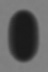

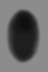

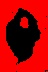

[136 136 136 136 135] [140 140 140 140 140]


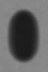

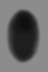

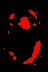

[131 131 132 131 131] [140 140 140 140 140]


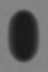

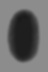

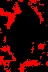

[130 130 130 130 129] [140 140 140 140 140]


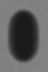

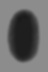

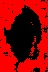

[132 131 131 130 130] [140 140 140 140 140]


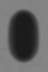

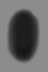

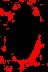

In [238]:
test_valid2(add_bt_model_not_freeze, _test_dataloader, config_dic['device'])

In [236]:
def train_imshow(img):
    from IPython.display import display, Image
#     print(img.shape, np.max(img[0]), img[0][:10], np.mean(img), np.min(img[0]))
    _, ret = cv2.imencode('.jpg', img)
    img = Image(data=ret)
    display(img)
    
    
def mask(img1, img2):
    zeros_img = np.zeros((3, *img1.shape))
#     print(zeros_img.shape)
    mask_img = np.absolute(img1.astype(np.int32) - img2.astype(np.int32))
    
    mask_img[mask_img < 10] = 0
    mask_img[mask_img >= 10] = 255
    zeros_img[2] = mask_img
    zeros_img = np.transpose(zeros_img, (1,2,0)).astype(np.uint8)
    train_imshow(zeros_img)